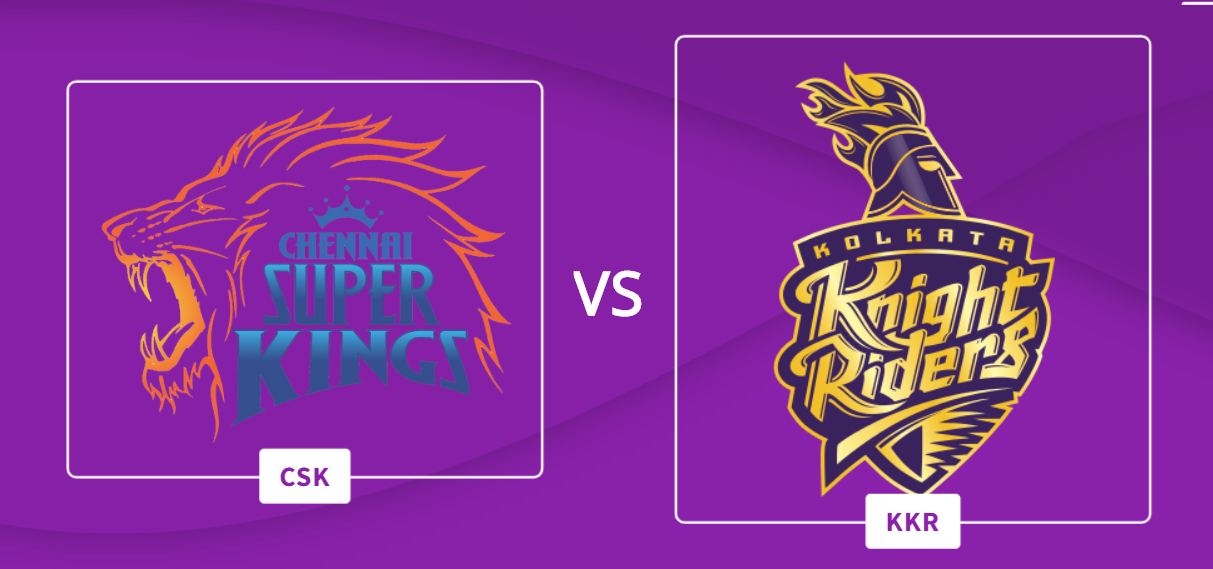

In [1]:
#!pip install bqplot
#!pip install ipywidgets
#!pip install ipympl
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
#!jupyter nbextension install --user --py widgetsnbextension
#!jupyter nbextension enable --user --py widgetsnbextension
#!pip install plotly
#!pip install cufflinks


import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import ipywidgets as widgets
import plotly.express as px
import plotly.graph_objects as go
import bqplot
from bqplot import Pie
from collections import Counter
from bqplot import DateScale, LinearScale, Lines, Axis, Figure
from bqplot import Tooltip
import cufflinks as cf
from matplotlib.patches import ConnectionPatch
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))


from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
pd.set_option('display.max_columns', 50)
%matplotlib widget


In [2]:
matches = pd.read_csv("matches.csv")
deliveries =  pd.read_csv("deliveries.csv")
IPL_data = pd.merge(deliveries, matches[['id','season', 'team1', 'team2', 'toss_winner', 'toss_decision','winner','result', 'dl_applied','win_by_runs','win_by_wickets', 'venue' ]], 
                    left_on='match_id', right_on='id')

In [24]:

KKR_batsmen = ['S Gill', 'N Rana', 'RA Tripathi',  'KD Karthik', 'EJG Morgan', 'SP Narine', 'AD Russell', 'PJ Cummins']
# SP Narine/AD Russell(optional)


KKR_bowlers = ['PJ Cummins',  'P Krishna', 'SP Narine', 'LH Ferguson', 'AD Russell', 'V Chakravarthy']
# LH ferguson instead of 
#nagarkoti not found

CSK_batsmen = ['F du Plessis', 'AT Rayudu', 'MS Dhoni', 'RA Jadeja','S Curran', 'DJ Bravo']
#R Gaikwad: No data
# Jagadeesan no data
CSK_bowlers = ['DL Chahar', 'S Curran','Imran Tahir', 'RA Jadeja', 'M Santner']
# M Kumar no data

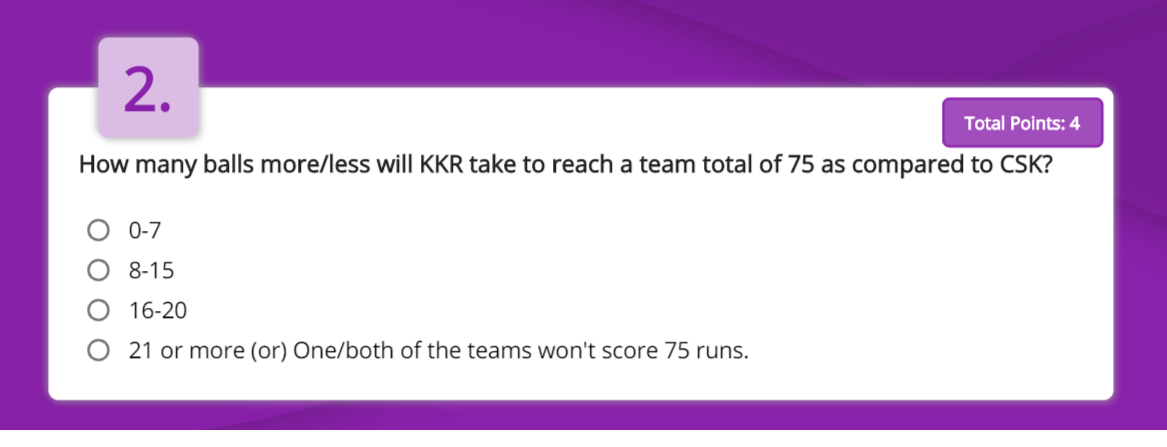

In [51]:
KKR_CSK_batsmen = deliveries[(deliveries.batsman.isin(CSK_batsmen)) | (deliveries.batsman.isin(KKR_batsmen))]
player = [];balls=[];runs=[]
for i in KKR_CSK_batsmen.batsman.unique():
    player.append(i)
    batsman = KKR_CSK_batsmen[KKR_CSK_batsmen.batsman == i]
    balls_faced = batsman.groupby(['match_id','batsman'])['batsman_runs'].count().reset_index(name = "balls_faced")
    balls.append(balls_faced.balls_faced.mean())
    runs_scored = batsman.groupby(['match_id','batsman'])['batsman_runs'].sum().reset_index(name = "runs_scored")
    runs.append(runs_scored.runs_scored.mean())

batsmen_scores = pd.DataFrame(list(zip(player, balls, runs)), 
               columns =["batsman", "balls_faced", "runs_scored"])    

CSK_scores = batsmen_scores[batsmen_scores.batsman.isin(CSK_batsmen)]
KKR_scores = batsmen_scores[batsmen_scores.batsman.isin(KKR_batsmen)]
display_side_by_side([CSK_scores, KKR_scores],["1) CSK batsmen scores","2) KKR batsmen scores"])

# Calculate cumulative scores batting order wise
def cumulative_scores(list_batsmen, data):
    for i in list_batsmen:
        batsmen.append(i)
        balls_required.append(data[data.batsman == i].balls_faced.values[0])
        scores.append(data[data.batsman == i].runs_scored.values[0])
        
    cumsum_batsmen_scores = pd.DataFrame(list(zip(batsmen, balls_required, scores)), 
               columns =["batsman", "balls_faced", "runs_scored"])
    return cumsum_batsmen_scores.cumsum()

balls_required=[];scores=[];batsmen=[]
cumsum_CSK = cumulative_scores(CSK_batsmen, CSK_scores)

balls_required=[];scores=[];batsmen=[]
cumsum_KKR = cumulative_scores(KKR_batsmen, KKR_scores)

display_side_by_side([cumsum_CSK, cumsum_KKR],["1) CSK batsmen scores(cumulative)","2) KKR batsmen scores(cumulative)"])

import numpy as np
import cufflinks as cf
def plot_scores(data_scores, label):
    cf.set_config_file(theme='pearl',sharing='public',offline=True)
    data_scores.iplot(kind="bar",x = "balls_faced",
                subplots=True,
                sortbars=True,
                keys = ["runs_scored"],
                title=label,
                theme="henanigans")
    
plot_scores(cumsum_CSK, "Runs scored by CSK batsmen (balls_faced to Runs Scored)")
plot_scores(cumsum_KKR, "Runs scored by KKR batsmen (balls_faced to Runs Scored)")

,batsman,balls_faced,runs_scored
1,AT Rayudu,19.427536,24.101449
2,MS Dhoni,19.517647,26.335294
6,F du Plessis,23.421875,29.281250
9,RA Jadeja,13.056000,15.608000
10,DJ Bravo,12.050505,15.131313
13,S Curran,6.875000,11.875000
,batsman,balls_faced,runs_scored
0,N Rana,20.365854,26.926829
3,KD Karthik,17.839506,22.765432
4,PJ Cummins,6.222222,8.555556


,batsman,balls_faced,runs_scored
0,F du Plessis,23.421875,29.281250
1,F du PlessisAT Rayudu,42.849411,53.382699
2,F du PlessisAT RayuduMS Dhoni,62.367058,79.717993
3,F du PlessisAT RayuduMS DhoniRA Jadeja,75.423058,95.325993
4,F du PlessisAT RayuduMS DhoniRA JadejaS Curran,82.298058,107.200993
5,F du PlessisAT RayuduMS DhoniRA JadejaS CurranDJ Bravo,94.348563,122.332307
,batsman,balls_faced,runs_scored
0,S Gill,16.695652,22.478261
1,S GillN Rana,37.061506,49.405090
2,S GillN RanaRA Tripathi,54.364536,72.768727


## Conclusion : As shown in above plot difference would be around 16-20

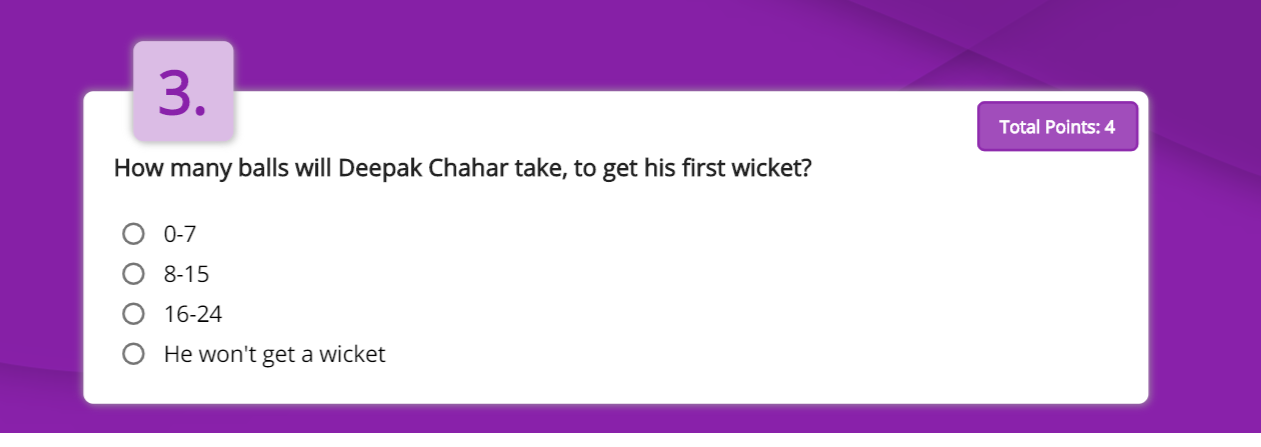

In [95]:
D_Chahar = deliveries[deliveries.bowler == 'DL Chahar']
D_Chahar.player_dismissed.fillna(0, inplace = True)
D_Chahar['player_dismissed'].loc[D_Chahar['player_dismissed'] != 0] = 1

def DL_chahar_wickets_data(data_):
    for i in data_.match_id.unique():
        match_num.append(i)
        match_data = data_[data_.match_id == i].reset_index()
        first_wicket = (match_data.player_dismissed.values != 0).argmax()
        wicket_details = match_data[:first_wicket]
        if wicket_details.batsman_runs.count() ==0:
            status.append("no_wicket")
        else:
            status.append("wicket")
        no_of_balls.append(wicket_details.batsman_runs.count())
    first_wicket_details = pd.DataFrame(list(zip(match_num, no_of_balls, status )), 
               columns =["match_id", "no_of_balls", "wicket_status"])

    return first_wicket_details

match_num = []; no_of_balls = [];status=[]
first_wicket_details_ = DL_chahar_wickets_data(D_Chahar)

pie_data1 = [(first_wicket_details_[first_wicket_details_.no_of_balls == 0].shape[0]/first_wicket_details_.shape[0])*100,
            (first_wicket_details_[first_wicket_details_.no_of_balls != 0].shape[0]/first_wicket_details_.shape[0])*100]
pie_labels1 = ["No wickets", "Wickets"]


In [177]:

from bqplot import Pie
from collections import Counter
from bqplot import DateScale, LinearScale, Lines, Axis, Figure
from bqplot import Tooltip

def pie_plot(pie_data,pie_labels, title):
    pie = Pie(sizes=list(pie_data), labels=list(pie_labels),
              stroke="black",
              opacities = [0.8, 0.8, 0.8],
              radius=180, inner_radius=80,
              sort=True,
              display_values=True, values_format='0.0f',
              label_color="white", font_size="12px", font_weight="bolder"
              )
    fig = Figure(marks=[pie],
             legend_location = "top",
             title=title,
             fig_margin= dict(top=60, bottom=40, left=50, right=20),
             background_style = {"fill":"black"}
                )
    fig.layout.width="800px"
    fig.layout.height="500px"
    pie.tooltip = Tooltip(fields=['sizes'], labels=["Count"], formats=["0.1f"])
    return fig
    
fig1  =pie_plot(pie_data1 ,pie_labels1, "DL Chahar's wickets percentage")
#fig1

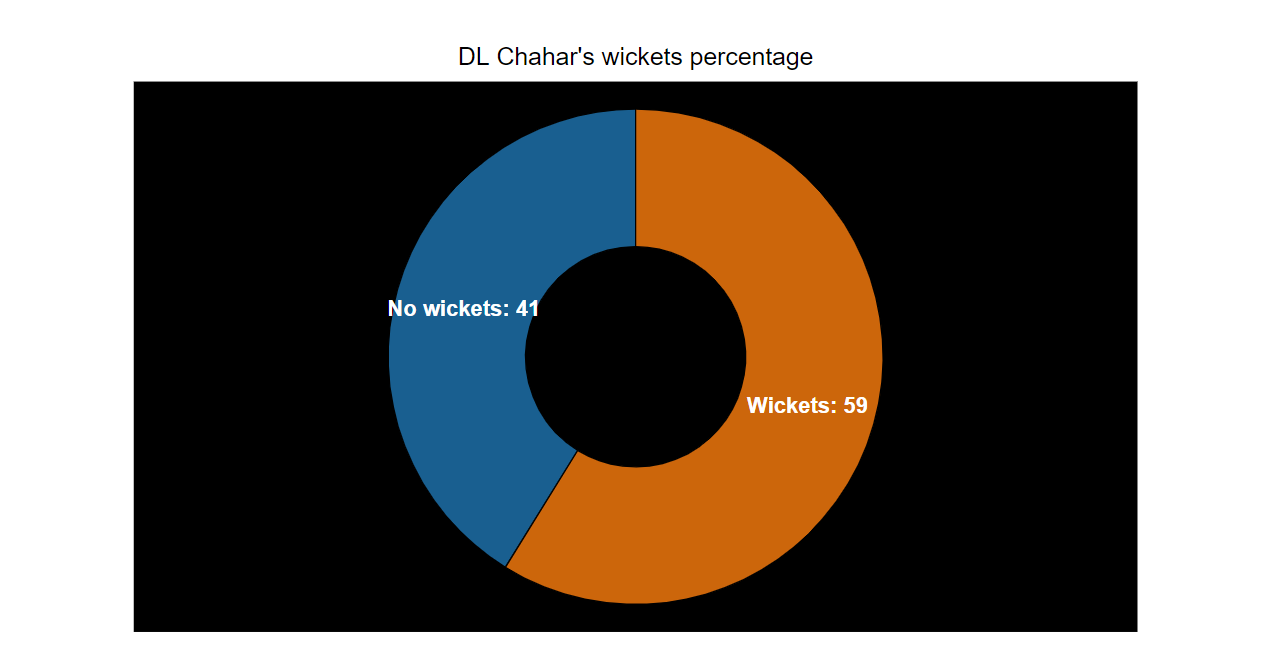

In [178]:
import numpy as np
import cufflinks as cf
DL_wickets = first_wicket_details[first_wicket_details.no_of_balls !=0].reset_index()
DL_wickets["index"] = DL_wickets.index

cf.set_config_file(theme='pearl',sharing='public',offline=True)
DL_wickets.iplot(kind="bar",x = "index",
                subplots=True,
                sortbars=True,
                keys = ["no_of_balls"],
                title="Number of balls taken by DL Chahar to take his 1st wicket",
                theme="henanigans")


In [179]:
print("Average Number of balls taken by Chahar to take his 1st wickets are", DL_wickets.no_of_balls.mean())

Average Number of balls taken by Chahar to take his 1st wickets are 10.35


## He will take 8-15 balls to take his 1st wicket

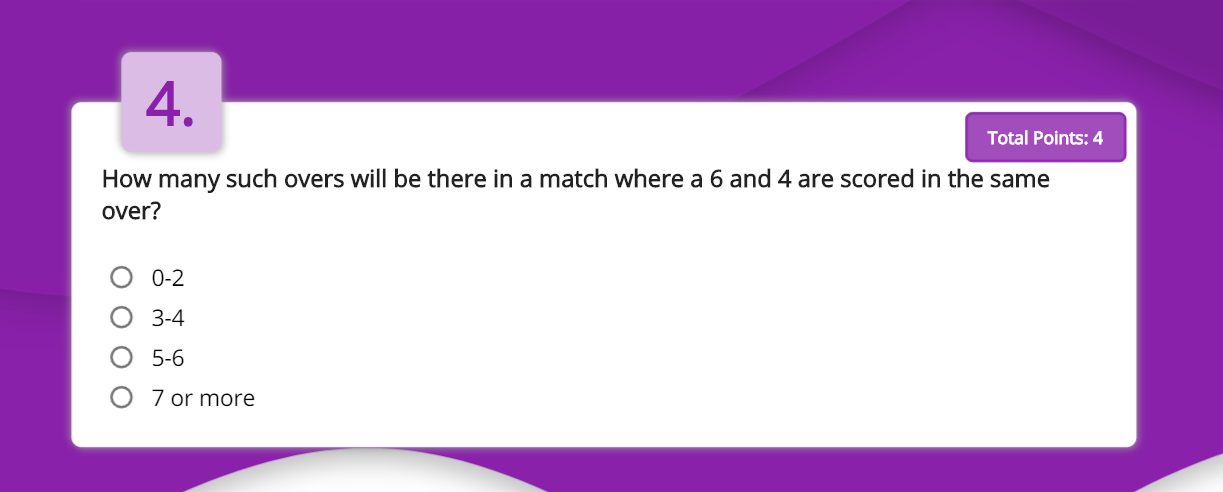

In [180]:
KKR_CSK_boundaries = KKR_CSK_batsmen[(KKR_CSK_batsmen.batsman_runs == 6) | (KKR_CSK_batsmen.batsman_runs == 4)]
m_id =[]; overs=[];overs_6_4=[];
for i in KKR_CSK_boundaries.match_id.unique():
    match = KKR_CSK_boundaries[KKR_CSK_boundaries.match_id == i]
    m_id.append(i)
    overs=[]
    for j in match.over.unique():
        over_score = match[match.over == j]
        score_ = over_score.batsman_runs.unique()
        if 6 in score_ and 4 in score_:
            overs.append(j)
            
    overs_6_4.append(len(overs))
    
    
boundary_overs = pd.DataFrame(list(zip(m_id, overs_6_4)), 
               columns =["match_id", "no_over_with_boundaries"])       

boundary_overs["index"] =boundary_overs.index
import numpy as np
import cufflinks as cf

cf.set_config_file(theme='pearl',sharing='public',offline=True)
boundary_overs.iplot(kind="bar",x = "index",
                subplots=True,
                sortbars=True,
                keys = ["no_over_with_boundaries"],
                title="Number of overs with 6 and 4 (matchwise)",
                theme="henanigans")

In [201]:
boundaries =[boundary_overs[boundary_overs.no_over_with_boundaries == 0].shape[0],
boundary_overs[boundary_overs.no_over_with_boundaries == 1].shape[0], 
boundary_overs[(boundary_overs.no_over_with_boundaries >=3) & (boundary_overs.no_over_with_boundaries <=4)].shape[0],
boundary_overs[(boundary_overs.no_over_with_boundaries >=5) & (boundary_overs.no_over_with_boundaries <=6)].shape[0],
boundary_overs[boundary_overs.no_over_with_boundaries > 7].shape[0]]

boundary_labels = ["0", "1 over", "3-4", "5-6", ">7"]
fig3= pie_plot(boundaries, boundary_labels, "Number of overs with 6 and 4")
#fig3

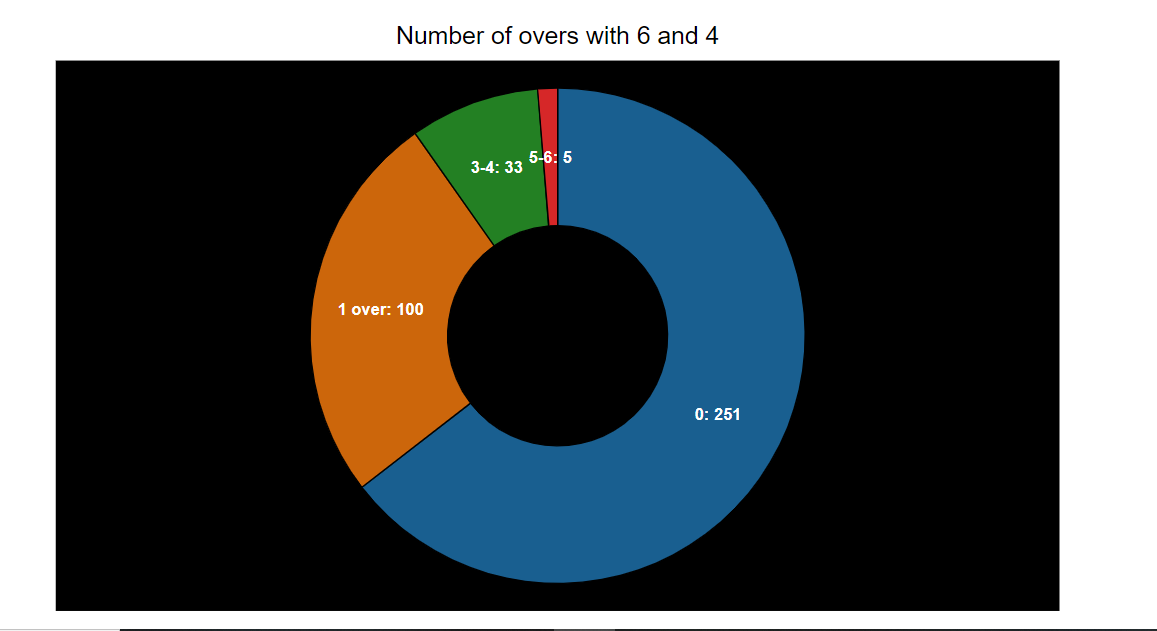

## Conclusion from above plot there will be 0-1 overs with 6 and 4 score

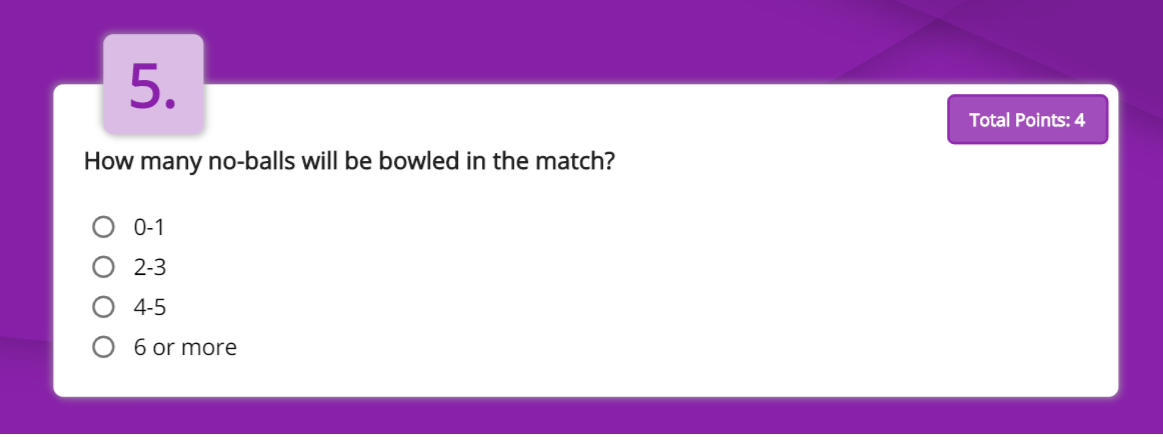

In [183]:
no_balls = deliveries[(deliveries.bowler.isin(CSK_bowlers)) | (deliveries.bowler.isin(KKR_bowlers))]
no_balls_csk_KKR = no_balls.groupby(['bowler'])['noball_runs'].sum().reset_index(name = "no_balls")
no_balls_csk_KKR

,bowler,no_balls
0,AD Russell,4
1,DL Chahar,5
2,Imran Tahir,1
3,LH Ferguson,0
4,M Santner,1
5,P Krishna,4
6,PJ Cummins,1
7,RA Jadeja,2
8,S Curran,1
9,SP Narine,2


In [191]:
noball = [];bowler = []
for i in no_balls.bowler.unique():
    bowler.append(i)
    noball.append(no_balls[no_balls.bowler == i].noball_runs.mean())
noball_total = pd.DataFrame(list(zip(bowler, noball)), 
               columns =["bowler", "noballs"])
noball_total


,bowler,noballs
0,DL Chahar,0.006868
1,Imran Tahir,0.000801
2,SP Narine,0.000769
3,PJ Cummins,0.002639
4,RA Jadeja,0.000787
5,LH Ferguson,0.000000
6,AD Russell,0.003731
7,P Krishna,0.009153
8,S Curran,0.004831
9,V Chakravarthy,0.000000


In [187]:
noball_total.noballs.sum()

0.0409428328728136

## No balls will be 0-1

# Question 1: Who will win the match?

In [193]:


bowling_avg = deliveries[(deliveries.bowler.isin(CSK_bowlers)) | (deliveries.bowler.isin(KKR_bowlers))]
bowling_avg.player_dismissed.fillna(0, inplace  = True)
bowling_avg['player_dismissed'].loc[bowling_avg['player_dismissed'] != 0] = 1

b_avg1 = bowling_avg.groupby(['bowler'])['player_dismissed'].sum().reset_index(name  = "wickets")
t_b =  bowling_avg.groupby(['bowler'])['batsman_runs'].count().reset_index(name  = "balls_bowled")
b_avg1["balls_bowled"] = t_b.balls_bowled
b_avg1["bowling_avg"] = b_avg1.wickets/b_avg1.balls_bowled


display_side_by_side([b_avg1[b_avg1.bowler.isin(CSK_bowlers)], b_avg1[b_avg1.bowler.isin(KKR_bowlers)]], 
                     [" 1) bowling average of CSK bowlers", " 2) bowling average of KKR bowlers"])


## Batting averages of all the batsmen

batsmen_runs_all =deliveries[(deliveries.batsman.isin(CSK_batsmen)) | (deliveries.batsman.isin(KKR_batsmen))]
b1_all = batsmen_runs_all.groupby(['batsman'])['batsman_runs'].sum().reset_index(name = "total_runs")
b = [];b_avg = [];tm = [];runs  = []
for i in batsmen_runs_all.batsman.unique():
    x = batsmen_runs_all[batsmen_runs_all.batsman == i]
    x.player_dismissed.fillna(0, inplace = True)
    x['player_dismissed'].loc[x['player_dismissed'] != 0] = 1
    #print(x[['match_id','player_dismissed']])
    y = x.groupby(['match_id'])['player_dismissed'].sum().reset_index(name = "out_count")
    z = x.groupby(['match_id'])['batsman_runs'].sum().reset_index(name = "runs")
    #print(y)
    b.append(i)
    b_avg.append(y.out_count.sum())
    runs.append(z.runs.sum())
    tm.append(y.shape[0])
    
bat_avg = pd.DataFrame(list(zip(b, b_avg, tm, runs)), 
               columns =['batsman','matches_out','total_matches', 'total_runs'])    

bat_avg["batting_average"] = bat_avg.total_runs/bat_avg.matches_out

display_side_by_side([bat_avg[bat_avg.batsman.isin(CSK_batsmen)], bat_avg[bat_avg.batsman.isin(KKR_batsmen)]], [" 1) batting average of CSK batsmen", " 2) batting average of KKR batsmen"])

,bowler,wickets,balls_bowled,bowling_avg
1,DL Chahar,33,728,0.045330
2,Imran Tahir,82,1249,0.065653
4,M Santner,4,88,0.045455
7,RA Jadeja,116,2541,0.045651
8,S Curran,11,207,0.053140
,bowler,wickets,balls_bowled,bowling_avg
0,AD Russell,60,1072,0.055970
3,LH Ferguson,5,87,0.057471
5,P Krishna,16,437,0.036613
6,PJ Cummins,19,379,0.050132


,batsman,matches_out,total_matches,total_runs,batting_average
1,AT Rayudu,114,138,3326,29.175439
2,MS Dhoni,118,170,4477,37.940678
6,F du Plessis,56,64,1874,33.464286
9,RA Jadeja,83,125,1951,23.506024
10,DJ Bravo,63,99,1498,23.777778
13,S Curran,4,8,95,23.750000
,batsman,matches_out,total_matches,total_runs,batting_average
0,N Rana,40,41,1104,27.600000
3,KD Karthik,140,162,3688,26.342857
4,PJ Cummins,6,9,77,12.833333


In [200]:
print("Batting average CSK batsmen" ,bat_avg[bat_avg.batsman.isin(CSK_batsmen)].batting_average.sum())
print("Batting average KKR batsmen" ,bat_avg[bat_avg.batsman.isin(KKR_batsmen)].batting_average.sum())
print("Bowling average CSK bowlers" ,b_avg1[b_avg1.bowler.isin(CSK_bowlers)].bowling_avg.sum())
print("Bowling average KKR bowlers" ,b_avg1[b_avg1.bowler.isin(KKR_bowlers)].bowling_avg.sum())

Batting average CSK batsmen 171.61420415104195
Batting average KKR batsmen 210.05290410986817
Bowling average CSK bowlers 0.2552281527987785
Bowling average KKR bowlers 0.3084344753019955


## From above values KKR will win today